# **MENTAL HEALTH SEGMENTATION**

**OBJECTIVES**
1. Analyse the linguistic patterns, sentiments and mental health indicators in our dataset.
2. Assess mental health risk facors
3. Build a predictive risk model
4. Support product development
5. Segment individuals into Risk categories



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## **PREPARE DATA**

We'll download the dataset from kaggle

In [2]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download bhavikjikadara/mental-health-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 607MB/s]


In [4]:
!unzip -q mental-health-dataset.zip

We'll write a wrangle function that reads in our csv data from kaggle into our dataframe

In [28]:
def wrangle(filepath):

  # Read CSV file
  df = pd.read_csv(filepath)

  # Change names of columns to lowercas
  df.columns = df.columns.str.lower()

  # Drop "timestamp" column
  df = df.drop(columns="timestamp")

  return df

In [13]:
df = wrangle("/content/Mental Health Dataset.csv")
print(df.shape)
df.head()

(292364, 16)


,gender,country,occupation,self_employed,family_history,treatment,days_indoors,growing_stress,changes_habits,mental_health_history,mood_swings,coping_struggles,work_interest,social_weakness,mental_health_interview,care_options
0,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


**INFORMATION ON OUR DATASET**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   gender                   292364 non-null  object
 1   country                  292364 non-null  object
 2   occupation               292364 non-null  object
 3   self_employed            287162 non-null  object
 4   family_history           292364 non-null  object
 5   treatment                292364 non-null  object
 6   days_indoors             292364 non-null  object
 7   growing_stress           292364 non-null  object
 8   changes_habits           292364 non-null  object
 9   mental_health_history    292364 non-null  object
 10  mood_swings              292364 non-null  object
 11  coping_struggles         292364 non-null  object
 12  work_interest            292364 non-null  object
 13  social_weakness          292364 non-null  object
 14  mental_health_interv

# **EXPLORE**

**Mental Health Treatment by Gender**

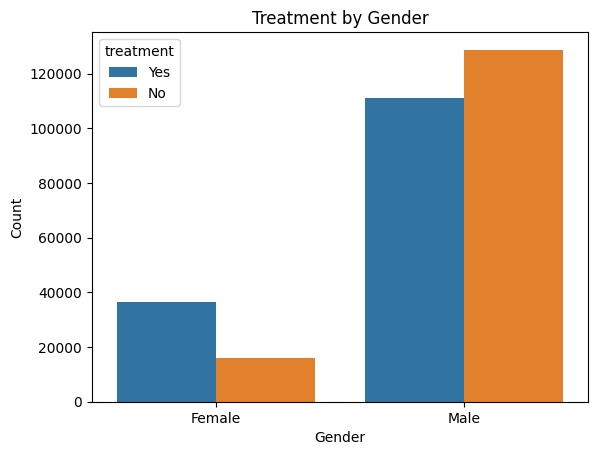

In [16]:
sns.countplot(x='gender', hue='treatment', data=df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Treatment by Gender")
plt.show()

The analysis shows that females are more likely to seek mental health treatment compared to males, indicating a higher level of awareness or willingness to access care. In contrast, males represent a larger untreated group, which may point to stigma, underreporting, or limited access to mental health services. From an actuarial point of view, the aspect of higher female frequency can be used in pricing health or mental riders.

**Mental Health Treatment By Family History**

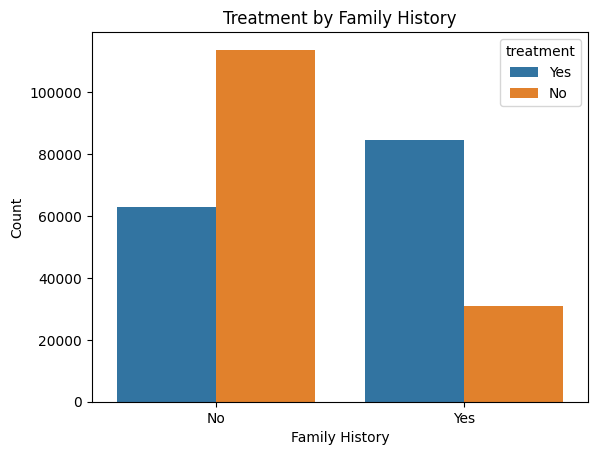

In [17]:
sns.countplot(data=df, x='family_history', hue='treatment')
plt.xlabel("Family History")
plt.ylabel("Count")
plt.title("Treatment by Family History")
plt.show()

Through the analysis, we observe a clear correlation between family history and mental health treatment. Individuals with a family history of mental health issues are more likely to seek treatment compared to those without such a background. This suggests that prior exposure increase the likelihood of recognizing symptoms and pursuing professional help, making family history a valuable predictor in actuarial risk modeling for mental health insurance.

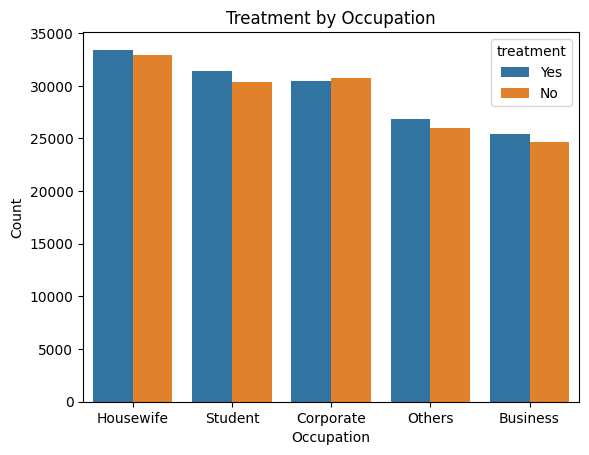

In [46]:
sns.countplot(x='occupation', hue='treatment', data=df, order=df['occupation'].value_counts().index)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Treatment by Occupation")
plt.show()

Occupation appears to influence treatment-seeking behavior, with housewives showing the highest uptake, suggesting a potentially higher claim frequency in this group. Corporate and student populations exhibit balanced treatment patterns, indicating stable utilization, while business professionals show comparatively lower engagement. These variations can be factored into actuarial models to differentiate premiums, assess expected claim costs, and tailor mental health products for specific occupational segments.

<Axes: xlabel='care_options', ylabel='count'>

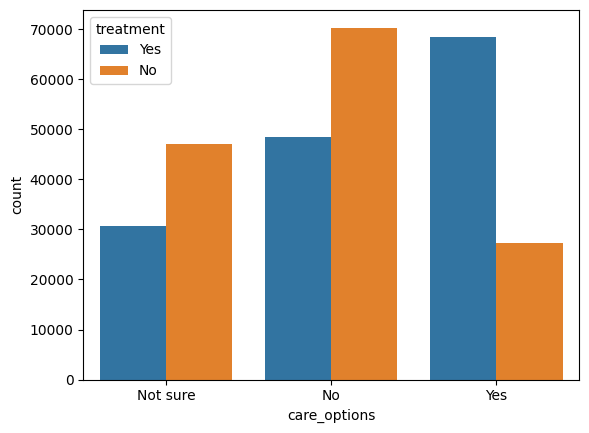

In [ ]:
sns.countplot(x='care_options', hue='treatment', data=df)


In [ ]:
pd.crosstab(df['self_employed'], df['growing_stress']).plot(kind='bar', stacked=True)


KeyError: 'growing_stress'